In [1]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier,RidgeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC
from tqdm import tqdm
import warnings
import csv
from xgboost import XGBClassifier
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestCentroid
from termcolor import colored



nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('stopwords')


c:\Users\matth\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading packa

True

In [2]:
embedding = 'sentence-transformers/all-MiniLM-L6-v2'

# 'BAAI/bge-large-en-v1.5'
# other embeddings: 'sentence-transformers/all-mpnet-base-v2'
# 'sentence-transformers/all-MiniLM-L6-v2'
# 'sentence-transformers/all-MiniLM-L12-v2'

In [3]:
df_train_plus = pd.read_csv("data/dataset_de_mort_and_food_custom.txt",names=['labels','sentences'],sep='\t')
df_train_plus['sentences'] = df_train_plus['sentences'].astype("str")
df_train_plus = df_train_plus[df_train_plus['sentences'].apply(lambda x: len(x.split()) >= 4)]
df_train_plus = df_train_plus.drop_duplicates(subset='sentences').reset_index(drop=True)
df_test = pd.read_csv("data/annotated_test.txt", sep=';',names=['labels','sentences'])
print(df_train_plus.shape,df_test.shape)
df_train_plus.head()

(5283, 2) (200, 2)


,labels,sentences
0,8,"Telescopes peer back in time, revealing the un..."
1,8,Quantum mechanics challenges our understanding...
2,8,Studying fossils unlocks the secrets of ancien...
3,8,Particle accelerators recreate the Big Bang's ...
4,8,Microbiology reveals invisible worlds teeming ...


In [26]:
df_test.labels.value_counts()

labels
6     32
7     19
1     19
2     18
9     17
4     16
5     16
11    15
10    14
8     13
0     11
3     10
Name: count, dtype: int64

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BiLSTM(nn.Module):

    def __init__(self, num_class, args, dimension=300):
        super(BiLSTM, self).__init__()
        self.args = args
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=384,
                            hidden_size=dimension//2, 
                            num_layers=4,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.1)
        self.hidden2tag = nn.Linear(dimension, num_class)

    def forward(self, sentences):
        
        output, (hidden,cell) = self.lstm(sentences)
        # output = self.drop(output)
        # last_output = output[:, -1, :]
        # print(hidden.shape) #torch.Size([8, 64, 150])
        last_output_forward = output[:, -1, :self.dimension//2]
        last_output_backward = output[:, 0, self.dimension//2:]
        last_output = torch.cat((last_output_forward, last_output_backward), dim=1)
        # last_output = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)#torch.Size([64, 300])
        # print(last_output.shape)
        last_output = self.hidden2tag(last_output)#torch.Size([64, 12])
        # print(last_output.shape)
        # batch_size = outputs.size(0)
        # seq_len = outputs.size(1)
        # last_output = output[:, -1, :]
        scores = F.log_softmax(last_output, 1)
        return scores

In [5]:
from torch.utils.data import DataLoader
import torchdata.datapipes as dp
from torchdata.datapipes.iter import IterableWrapper
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.optim as optim
import random

def shuffle_two_lists(a,b):
    combin = list(zip(a,b))
    random.shuffle(combin)
    first_elements = [t[0] for t in combin]
    second_elements = [t[1] for t in combin]
    return first_elements, second_elements
    
def prepare_data(data,model_name):
  
  model = SentenceTransformer(model_name)
  data = list(data)
  data = [sentence.split() for sentence in data]
  data = [model.encode(sentence) for sentence in data]
  return data

def group_sentences_by_length_with_labels(sentences, labels):
    grouped_data = {}
    sentences,labels = shuffle_two_lists(sentences,labels)
    for sentence, label in zip(sentences, labels):
        length = len(sentence)
        if length not in grouped_data:
            grouped_data[length] = {'sentences': [], 'labels': []}
        grouped_data[length]['sentences'].append(sentence)
        grouped_data[length]['labels'].append(label)
    return grouped_data

def create_batches_with_labels(grouped_data, batch_size):
    batches = []
    for length, data in grouped_data.items():
        sentences = data['sentences']
        labels = data['labels']
        for i in range(0, len(sentences), batch_size):
            batch_sentences = sentences[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            batches.append((batch_sentences, batch_labels))
    return batches


def train(model,batches,optimizer, ep, args):
    model.train()
    loss_it = list()
    for sentences,labels in tqdm(batches):
        sentences = torch.tensor(sentences)
        labels = torch.tensor(labels)
        optimizer.zero_grad()
        model.zero_grad()
        logits = model(sentences)
        
        if 'class_weights' in args:
            loss_fn = nn.NLLLoss(weight=args['class_weights'])  
        else: 
            loss_fn = nn.NLLLoss()
        
        # print(logits,labels)    
        loss = loss_fn(logits,labels)#.view(args["b_size"])

        loss.backward()
        optimizer.step()
        loss_it.append(loss.item())
  
    print("Epoch %s/%s : %s : (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it)))


In [6]:
def inference(model,target,data):

  model.eval()
  liste_pred = []
  with torch.no_grad():
    for sentence in data:
      sentence = torch.tensor([sentence])
      # print(sentence)
      logits = model(sentence)
      results = torch.argmax(logits,dim=1)
      liste_pred.append(results.item())
    acc = (liste_pred == target).sum()/len(target)
    return liste_pred,acc
  
def run_epochs(model,sentences,labels,args):
  optimizer = optim.Adam(model.parameters(), lr = args['lr'],weight_decay=0.0001)
  
  for ep in range(args['max_eps']):
    grouped_sentences = group_sentences_by_length_with_labels(sentences,labels)
    batches = create_batches_with_labels(grouped_sentences, args['bsize'])
    print(batches)
    print(batches[0].shape)
    train(model,batches, optimizer, ep, args)

In [8]:
#50 epochs

args = {'bsize': 128}
args.update({'max_eps': 50, 'lr': 0.0005, 'device': 'cpu', 'num_class': 12})
# nb_data = 1000
sentences = prepare_data(df_train_plus.loc[:,'sentences'],embedding)
model = BiLSTM( args['num_class'], args, dimension=1024)
loss_list_val = run_epochs(model,sentences,list(df_train_plus.loc[:,'labels']), args)
   

100%|██████████| 119/119 [11:53<00:00,  5.99s/it]


Epoch 0/50 : Training : (loss 2.456820712370031)


100%|██████████| 119/119 [06:19<00:00,  3.19s/it]


Epoch 1/50 : Training : (loss 2.3939943083194124)


100%|██████████| 119/119 [05:16<00:00,  2.66s/it]


Epoch 2/50 : Training : (loss 2.06515030299916)


100%|██████████| 119/119 [03:28<00:00,  1.75s/it]


Epoch 3/50 : Training : (loss 1.9915777278297089)


100%|██████████| 119/119 [03:17<00:00,  1.66s/it]


Epoch 4/50 : Training : (loss 1.929308160575999)


100%|██████████| 119/119 [03:00<00:00,  1.52s/it]


Epoch 5/50 : Training : (loss 1.900914140609132)


100%|██████████| 119/119 [17:35<00:00,  8.87s/it] 


Epoch 6/50 : Training : (loss 1.78210346200386)


 29%|██▉       | 35/119 [01:54<03:42,  2.65s/it]

In [4]:
sentences = prepare_data(df_test.loc[:,'sentences'],embedding)
pred,score = inference(model,df_test.loc[:,'labels'],sentences)

NameError: name 'prepare_data' is not defined

c:\Users\matth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\matth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\matth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.42      0.84      0.56        19
           2       0.81      0.72      0.76        18
           3       0.50      0.20      0.29        10
           4       0.00      0.00      0.00        16
           5       0.38      0.94      0.54        16
           6       1.00      0.12      0.22        32
           7       1.00      0.16      0.27        19
           8       0.33      0.77      0.47        13
           9       0.91      0.59      0.71        17
          10       0.40      0.71      0.51        14
          11       0.65      0.73      0.69        15

    accuracy                           0.52       200
   macro avg       0.60      0.55      0.48       200
weighted avg       0.64      0.52      0.46       200



<Axes: >

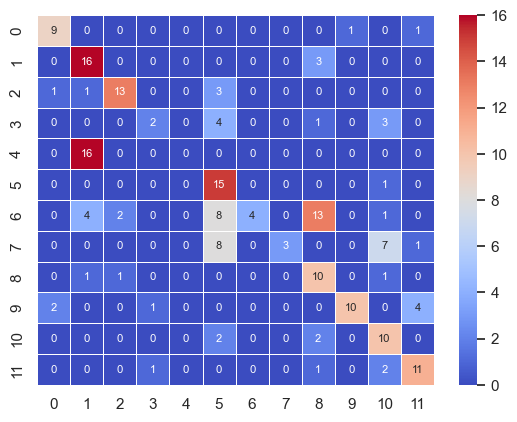

In [51]:
report = classification_report(df_test.loc[:, "labels"], pd.Series(pred))
print(report)
cm = confusion_matrix(df_test.loc[:, "labels"], pd.Series(pred))
df_cm = pd.DataFrame(cm, index=list(range(12)), columns=list(range(12)))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5)

In [16]:
vectors = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
threshold = np.array([1,4,5,6,8,1,3,0,4,6])
row_indices= np.where(vectors > threshold)

In [17]:
row_indices

(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int64),
 array([5, 6, 7, 8, 9, 5, 6, 7, 8, 9], dtype=int64))

In [ ]:
# weights =  {6:95/149,1:95/119,5:95/111,0:95/118,7: 95/97,9: 95/97,10:95/90,2: 95/86,11:95/85,3: 95/72,8: 95/57,4: 95/59}
# finetuned_llm('sentence-transformers/all-MiniLM-L6-v2',model_name_classifier,df_train_plus,df_test)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       0.70      0.74      0.72        19
           2       0.94      0.83      0.88        18
           3       0.80      0.80      0.80        10
           4       0.77      0.62      0.69        16
           5       0.94      1.00      0.97        16
           6       0.90      0.88      0.89        32
           7       0.90      1.00      0.95        19
           8       0.64      0.69      0.67        13
           9       0.84      0.94      0.89        17
          10       0.93      0.93      0.93        14
          11       0.92      0.73      0.81        15

    accuracy                           0.85       200
   macro avg       0.84      0.85      0.84       200
weighted avg       0.85      0.85      0.85       200



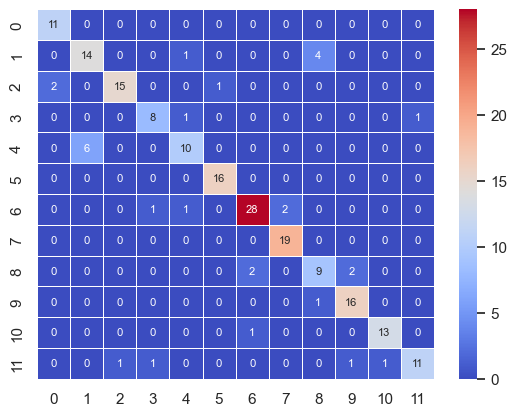

In [18]:
from clean_code.utilities import  load_prediction,evaluation

pred = load_prediction("lol2")
# pred = pd.read_csv("results/test.csv")
evaluation([pred],df_test)


In [25]:
# np.mean(df_test["labels"]==pred)
df_test["pred"] = pred
for elem in np.array(df_test[(df_test["labels"] !=df_test["pred"])]):
    print(elem)



[10
 'The benefits of biomimicry are many, including potential for developing sustainable technologies and improving efficiency.'
 6]
[2
 'The impact of demographic changes on the economy is a topic of concern.'
 0]
[4
 'The importance of portion control in maintaining a healthy weight cannot be overemphasized.'
 1]
[4 'The impact of food deserts on community health is a topic of concern.'
 1]
[11
 'The best way to find the best local attractions is to do your research ahead of time.'
 3]
[3 'The best way to find the best local nightlife is to ask the locals.'
 11]
[11
 'The film producer secured funding for their next project through crowdfunding.'
 2]
[6
 'The impact of the gig economy on sustainable travel is a topic of ongoing debate.'
 3]
[11
 'The reality competition show pits contestants against each other in a series of challenges.'
 9]
[3
 'The best way to find the best local food tours is to do your research ahead of time.'
 4]
[1
 'The impact of climate change on human healt

In [ ]:
#rajouter des phrases avec healthy dedans et dire que c'est food (4 1)
#ongoing scientific research --> forcement scientifique?

In [27]:
df_test.labels.value_counts()

labels
6     32
7     19
1     19
2     18
9     17
4     16
5     16
11    15
10    14
8     13
0     11
3     10
Name: count, dtype: int64